In [1]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import soundfile as sf
from lib import *

In [2]:
# Initialize lists to store audio data and sample rates
rir = np.zeros((2, 21, 6), dtype=object) # room impluse response
sr = np.zeros((2, 21, 6), dtype=object) # sample rate
early_echo_index = np.zeros((2, 21, 6), dtype=object) # early echo index
early_echo_time = np.zeros((2, 21, 6), dtype=object) # early echo time
# Load audio files
folder = './data/RIRs/'
sr = int(48e3)
for i in range(1, 3):  # speaker
    for j in range(0, 21):  # position
        for k in range(1, 7):  # microphone
            if j < 10:
                file_path = os.path.join(folder,f's{i}_p0{j}_m{k}.wav')
            else:
                file_path = os.path.join(folder,f's{i}_p{j}_m{k}.wav')
            rir[i-1, j, k-1] = sf.read(file_path)[0]
            early_echo_index[i-1, j, k-1],early_echo_time[i-1, j, k-1] = edc_analyze(rir[i-1,j,k-1], sr,threshold=10e-2, plot=False)

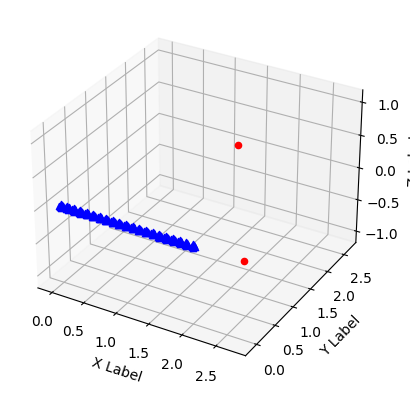

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create positions for mics and speakers in meters
p_speaker = np.zeros((2, 3))
p_speaker[0] = np.array([1.2, 2.6, 0])
p_speaker[1] = np.array([0.34 + 2.39, 0, 0])  # Adjusted from p_speaker[2] to p_speaker[1]
p_mic = np.zeros((21, 6, 3))  # Adjusted for better performance and consistency
Radius = 0.025  # 25 mm
for j in range(0, 21):  # position
    p_center = np.array([j, 0, 0]) * 0.1
    p_mic[j, 0] = p_center + np.array([0, -Radius, 0])
    p_mic[j, 1] = p_center + np.array([0, Radius, 0])
    p_mic[j, 2] = p_center + np.array([-Radius, 0, 0])
    p_mic[j, 3] = p_center + np.array([Radius, 0, 0])
    p_mic[j, 4] = p_center + np.array([0, 0, Radius])
    p_mic[j, 5] = p_center + np.array([0, 0, -Radius])

# Plot all mics and speakers
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*p_speaker[0], c='r', marker='o')
ax.scatter(*p_speaker[1], c='r', marker='o')
for i in range(0, 21):
    for j in range(0, 6):
        ax.scatter(*p_mic[i, j], c='b', marker='^')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.axis('equal')
plt.show()


In [4]:
rir_early = np.zeros((2, 21, 6), dtype=object)
for i in range(1, 3):  # speaker
    for j in range(0, 21):  # position
        for k in range(1, 7):  # microphone
            rir_early[i-1, j, k-1] = rir[i-1, j, k-1][0:early_echo_index[i-1, j, k-1]]

Shape of DTW Matrix: (12169, 11835)


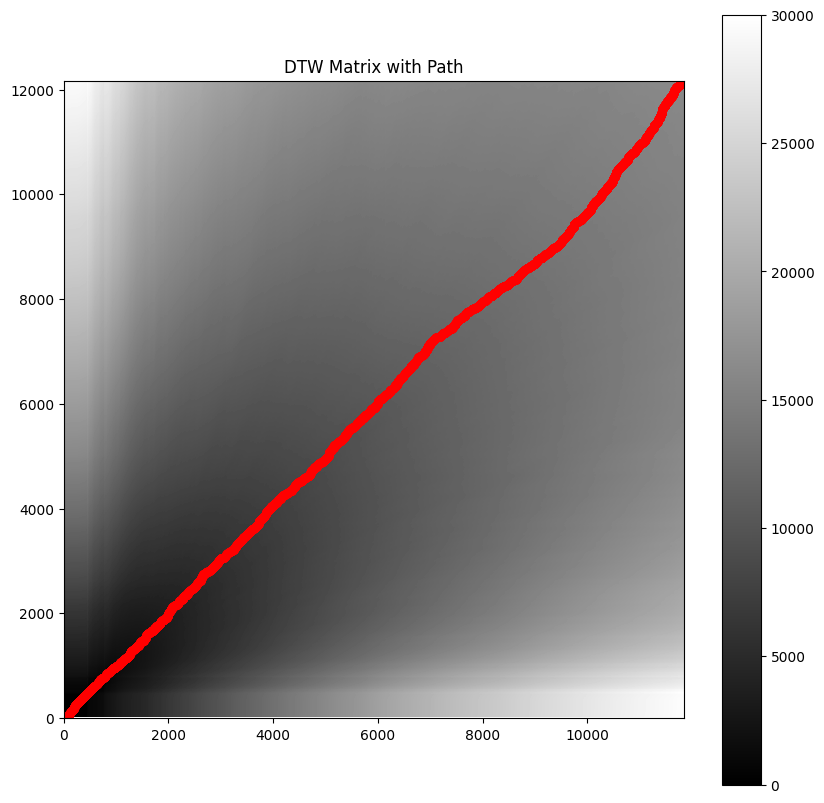

In [9]:
s = rir_early[0, 0, 0]
t = rir_early[0, 5, 0]
dtw_matrix,path = cal_dtw_matrix(s, t)
plot_dtw_matrix(dtw_matrix, path)

In [17]:
path

array([[    0,     0],
       [    1,     1],
       [    2,     2],
       ...,
       [12166, 11832],
       [12167, 11833],
       [12168, 11834]])

In [10]:
# Wrap s and t based on the computed DTW path
wrapped_s = []
wrapped_t = []

for i, j in path:
    wrapped_s.append(s[i-1])
    wrapped_t.append(t[j-1])

# Convert wrapped_s and wrapped_t to NumPy arrays
wrapped_s = np.array(wrapped_s)
wrapped_t = np.array(wrapped_t)


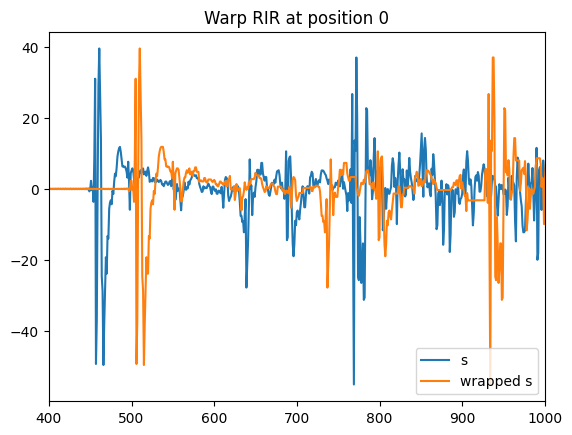

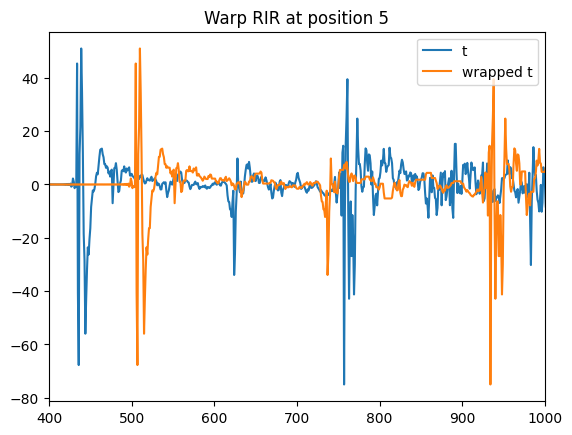

In [16]:
#plot the wrapped signals and original signals
plt.figure()
plt.plot(s, label='s')
plt.plot(wrapped_s, label='wrapped s')
plt.legend()
plt.title('Warp RIR at position 0')
plt.xlim(400, 1000)
plt.show()

plt.plot(t, label='t')
plt.plot(wrapped_t, label='wrapped t')
plt.legend()
plt.title('Warp RIR at position 5')
plt.xlim(400, 1000)
plt.show()



In [6]:
p_interpolation = np.zeros((20, 6, 3))  # Assuming you want to store 3D coordinates
for j in range(20):  # position
    for k in range(6):  # microphone
        # Create an array with the two points and calculate the mean along axis 0
        p_interpolation[j, k] = np.mean([p_mic[j, k], p_mic[j+1, k]], axis=0)

d_mic_speaker = np.zeros((2, 21, 6), dtype=object)
for i in range(2):  # speaker
    for j in range(21):  # position
        for k in range(6):  # microphone
            d_mic_speaker[i,j,k] = np.linalg.norm(p_mic[j, k] - p_speaker[i])

d_interpolation_speaker = np.zeros((2, 20, 6), dtype=object)
for i in range(2):  # speaker
    for j in range(20):  # position
        for k in range(6):  # microphone
            d_interpolation_speaker[i,j,k] = np.linalg.norm(p_interpolation[j, k] - p_speaker[i])

alpha = np.zeros((2, 20, 6), dtype=object)
for i in range(2):  # speaker
    for j in range(20):  # position
        for k in range(6):  # microphone
            alpha[i,j,k] = (1/d_mic_speaker[i,j,k]-1/d_interpolation_speaker[i,j,k])/(1/d_mic_speaker[i,j,k]-1/d_mic_speaker[i,j+1,k])

In [13]:
# from scipy.signal import find_peaks

# # Assuming cal_dtw_matrix returns both dtw_matrix and path
# for i in range(2):
#     for j in range(20):
#         for k in range(6):
#             dtw_matrix, path = cal_dtw_matrix(rir_early[i, j, k], rir_early[i, j+1, k])
#             print("dtw matrix calculated")
#             s_warp_vec = path[:,0]
#             s_warp = np.array([])
#             for m in range(0, len(s_warp_vec)):
#                 s_warp = np.append(s_warp, rir_early[i, j, k][s_warp_vec[m]-1])
#             t_warp_vec = path[:,1]
#             t_warp = np.array([])
#             for n in range(0, len(t_warp_vec)):
#                 t_warp = np.append(t_warp, rir_early[i, j+1, k][t_warp_vec[n]-1])
#             i_warp = alpha[i,j,k]*s_warp+(1-alpha[i,j,k])*t_warp
#             print("i_warp calculated")
#             # align the warped i_warp with the theoretical rir
#             peaks_s, _ = find_peaks(rir_early[i, j, k], height=10, distance=1000)
#             peaks_t, _ = find_peaks(rir_early[i, j+1, k], height=10, distance=1000)
#             peaks_i, _ = find_peaks(i_warp, height=10, distance=1000)
#             shift = int((peaks_t[0] + peaks_s[0]) / 2) - int(peaks_i[0])
#             i_warp = np.roll(i_warp, shift)
#             # crop the i_warp as the length of the original rir
#             i_warp = i_warp[0:len(rir_early[i, j, k])]
#             # write the i_warp into wav file
#             sf.write(f'./data/iRIRs/s{i}_p{j}_m{k}.wav', i_warp, sr,subtype="FLOAT")
#             print("i_warp written")

In [14]:
from scipy.signal import find_peaks
from fastdtw import fastdtw
from tqdm import tqdm

# Assuming cal_dtw_matrix returns both dtw_matrix and path
for i in tqdm(range(2), desc='Speakers', leave=True):
    for j in tqdm(range(20), desc='Positions', leave=False):
        for k in range(6):
            distance, path = fastdtw(rir_early[i, j, k].tolist(), rir_early[i, j+1, k].tolist())
            s_warp_vec = [point[0] for point in path]
            s_warp = np.array([])
            for m in range(0, len(s_warp_vec)):
                s_warp = np.append(s_warp, rir_early[i, j, k][s_warp_vec[m]-1])
            t_warp_vec = [point[1] for point in path]
            t_warp = np.array([])
            for n in range(0, len(t_warp_vec)):
                t_warp = np.append(t_warp, rir_early[i, j+1, k][t_warp_vec[n]-1])
            i_warp = alpha[i,j,k]*s_warp+(1-alpha[i,j,k])*t_warp
            # align the warped i_warp with the theoretical rir
            peaks_s, _ = find_peaks(rir_early[i, j, k], height=10, distance=1000)
            peaks_t, _ = find_peaks(rir_early[i, j+1, k], height=10, distance=1000)
            peaks_i, _ = find_peaks(i_warp, height=10, distance=1000)
            shift = int((peaks_t[0] + peaks_s[0]) / 2) - int(peaks_i[0])
            i_warp = np.roll(i_warp, shift)
            # crop the i_warp as the length of the original rir
            i_warp = i_warp[0:len(rir_early[i, j, k])]
            # write the i_warp into wav file
            if j < 10:
                sf.write(f'./data/RIRs/s{i+1}_p0{j}i_m{k+1}.wav', i_warp, sr,subtype="FLOAT")
            else:
                sf.write(f'./data/RIRs/s{i+1}_p{j}i_m{k+1}.wav', i_warp, sr,subtype="FLOAT")

Speakers: 100%|██████████| 2/2 [03:27<00:00, 103.72s/it]


In [8]:
from scipy.signal import find_peaks
from fastdtw import fastdtw
from tqdm import tqdm

# Assuming cal_dtw_matrix returns both dtw_matrix and path
for j in tqdm(range(19), desc="Positions", leave=False):
    for k in range(6):
        distance, path = fastdtw(
            rir_early[1, j, k].tolist(), rir_early[1, j + 2, k].tolist()
        )
        s_warp_vec = [point[0] for point in path]
        s_warp = np.array([])
        for m in range(0, len(s_warp_vec)):
            s_warp = np.append(s_warp, rir_early[1, j, k][s_warp_vec[m] - 1])
        t_warp_vec = [point[1] for point in path]
        t_warp = np.array([])
        for n in range(0, len(t_warp_vec)):
            t_warp = np.append(t_warp, rir_early[1, j + 2, k][t_warp_vec[n] - 1])
        i_warp = alpha[1, j, k] * s_warp + (1 - alpha[1, j, k]) * t_warp
        # align the warped i_warp with the theoretical rir
        peaks_s, _ = find_peaks(rir_early[1, j, k], height=10, distance=1000)
        peaks_t, _ = find_peaks(rir_early[1, j + 2, k], height=10, distance=1000)
        peaks_i, _ = find_peaks(i_warp, height=10, distance=1000)
        shift = int((peaks_t[0] + peaks_s[0]) / 2) - int(peaks_i[0])
        i_warp = np.roll(i_warp, shift)
        # crop the i_warp as the length of the original rir
        i_warp = i_warp[0 : len(rir_early[1, j, k])]
        # write the i_warp into wav file
        if j < 10:
            sf.write(
                f"./data/RIRs/s2_p0{j}t_m{k+1}.wav", i_warp, sr, subtype="FLOAT"
            )
        else:
            sf.write(
                f"./data/RIRs/s2_p{j}t_m{k+1}.wav", i_warp, sr, subtype="FLOAT"
            )

IndexError: index 21 is out of bounds for axis 1 with size 21